In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import pathlib
import os

In [2]:
from pathlib import Path

positive_directory = Path('data/Positive')
negative_directory = Path('data/Negative')
uncertain_directory = Path('data/Uncertain')

positive_labels_file = "data/Positive/Positive.xlsx"
negative_labels_file = "data/Negative/Negative.xlsx"
uncertain_labels_file = "data/Uncertain/Uncertain.xlsx"

In [3]:
from skimage.feature import graycomatrix, graycoprops, hog
from skimage import data, exposure

X = []
y = []

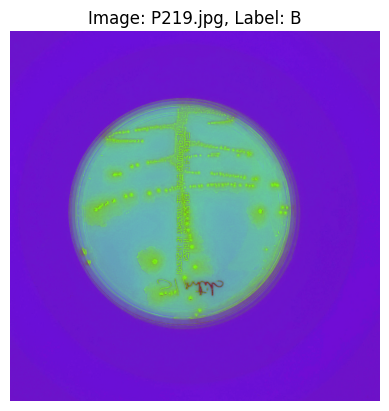

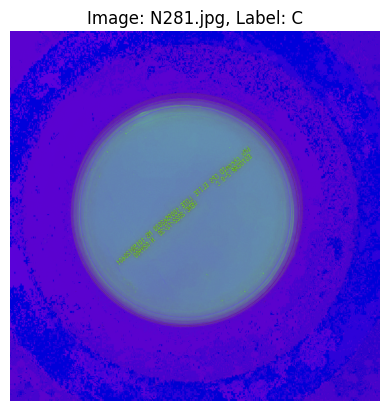

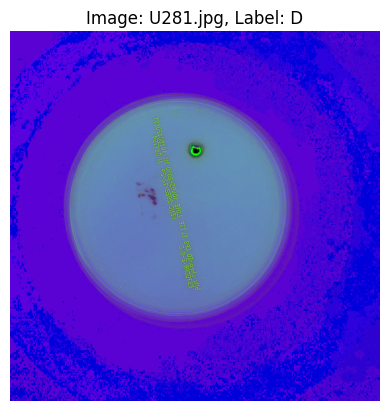

Loaded 1500 images with circular extraction into memory
Total class A: 135
Total class B: 363
Total class C: 500
Total class D: 40
Total class E: 462


In [4]:
datasets = [
    (positive_labels_file, positive_directory),
    (negative_labels_file, negative_directory),
    (uncertain_labels_file, uncertain_directory),
]

total_images = 0
for labels_file, directory in datasets:
    total_images += len(list(directory.glob('*.jpg')))

img_height, img_width = 64, 64


total_class_a = 0
total_class_b = 0
total_class_c = 0
total_class_d = 0
total_class_e = 0

idx = 0
for labels_file, directory in datasets:
    labels_df = pd.read_excel(labels_file)
    label_dict = dict(zip(labels_df['fileName'], labels_df['Label'])) 
    
    for file in directory.glob('*.jpg'):
        if file.is_file():
            img = cv2.imread(str(file))
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            
            
            img_resized = cv2.resize(img, (img_height, img_width))

            if idx == 133 or idx == 700 or idx== 1200:
                plt.imshow(img)
                plt.imshow(img_rgb)
                plt.title(f"Image: {file.name}, Label: {label_dict.get(file.name, 'E')}")
                plt.axis('off')
                plt.show()
            
            # Normalize
            img_normalized = img_resized / 255.0
            
            # Flatten for feature vector
            features = img_normalized.flatten()
            X.append(features)
            
            # Process labels
            label_letter = label_dict.get(file.name, 'E')
            dict_label = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
            y.append(dict_label.get(label_letter, 4))

            match label_letter:
                case 'A':
                    total_class_a += 1
                case 'B':
                    total_class_b += 1
                case 'C':
                    total_class_c += 1
                case 'D':
                    total_class_d += 1
                case 'E':
                    total_class_e += 1
            #print(idx)
            idx += 1

print(f"Loaded {idx} images with circular extraction into memory")
print(f"Total class A: {total_class_a}")
print(f"Total class B: {total_class_b}")
print(f"Total class C: {total_class_c}")
print(f"Total class D: {total_class_d}")
print(f"Total class E: {total_class_e}")

In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)


In [8]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import xgboost as xgb
classifier = xgb.XGBClassifier()

scores = cross_val_score(classifier, X_train, y_train, cv=5)
print('Cross-validation scores:', scores)
print('Mean accuracy:', np.mean(scores))


classifier.fit(X_train, y_train)
print('Test accuracy:', classifier.score(X_test, y_test))

Cross-validation scores: [0.9225 0.88   0.8975 0.8775 0.875 ]
Mean accuracy: 0.8905000000000001
Test accuracy: 0.916


In [9]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = classifier.predict(X_test)
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       110
           1       0.87      0.91      0.89       100
           2       0.96      0.96      0.96       104
           3       0.99      1.00      0.99        94
           4       0.84      0.75      0.79        92

    accuracy                           0.92       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.91      0.92      0.91       500



In [10]:
from sklearn.metrics import accuracy_score

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.916


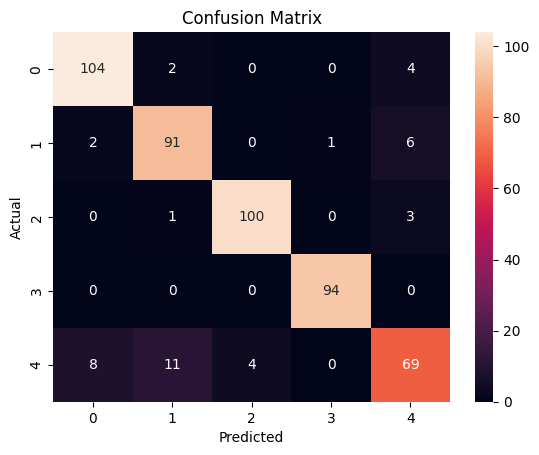

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [12]:
# function to predict on a single image

def test_from_image(filepath):
    img = cv2.imread(str(filepath))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(img_gray, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    features = [contrast, dissimilarity, homogeneity, energy, correlation]
    features = np.array(features).reshape(1, -1)

    predicted_label = classifier.predict(features)[0]
    print(f'File: {filepath}, Predicted Label: {predicted_label}')
    return predicted_label
